### Hertz model fitting (Dongwon Ha, 07/08/2025)

In [28]:
from igor2.binarywave import load
import matplotlib.pyplot as plt
import numpy as np

#### 1. Post-processing of the Experimental Data

- The force ($F$)–displacement ($\delta$) curve obtained from the AFM device contains both loading and unloading stages. In this study, only the loading stage was used for Hertz model fitting. To do so, the portion of the curve from the point where the force begins to increase to the maximum loading point was extracted.

In [29]:
# Read experiment data
filename = "force_displacement.ibw"

# Load the .ibw file
with open(filename, "rb") as f:
    data = load(f)

displ = (data['wave']['wData'][:,0]-data['wave']['wData'][0,0])*(10**6) # change the unit into um
force = data['wave']['wData'][:,1]-data['wave']['wData'][0,1]

# find the starting/end point for the force-displacement curve
threshold = 1e-9  
min_idx = np.argmax(force > threshold) # starting point where the force starts to increase
max_idx = np.argmax(force) # end point with the maximum force 

displ_exp = displ[min_idx:max_idx]-displ[min_idx]
force_exp = force[min_idx:max_idx]-force[min_idx]

<Figure size 640x480 with 0 Axes>

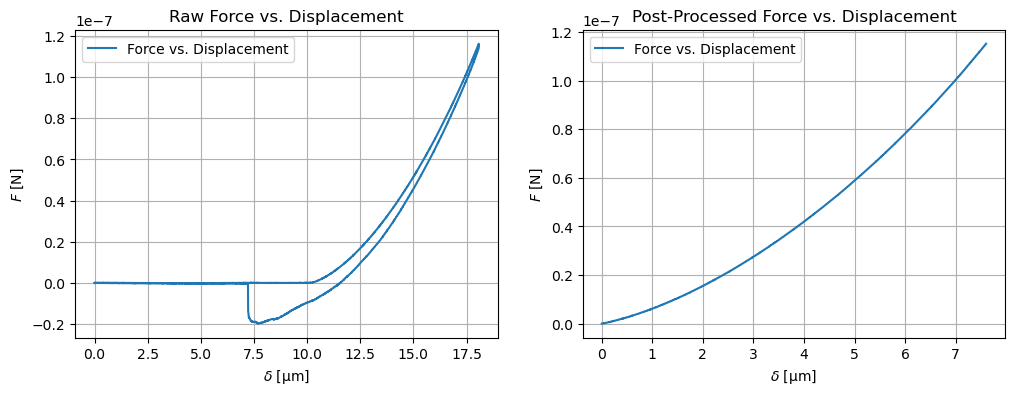

In [30]:
# Plot the raw/post-processed experiment data 
plt.figure(1)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # 2 rows, 1 column

# Plot raw data
axs[0].plot(displ, force, label='Force vs. Displacement')
axs[0].set_xlabel(r'$\delta$ [μm]')
axs[0].set_ylabel(r'$F$ [N]')
axs[0].set_title('Raw Force vs. Displacement')
axs[0].legend()
axs[0].grid(True)

# Plot post-processed data
axs[1].plot(displ_exp, force_exp, label='Force vs. Displacement')
axs[1].set_xlabel(r'$\delta$ [μm]')
axs[1].set_ylabel(r'$F$ [N]')
axs[1].set_title('Post-Processed Force vs. Displacement')
axs[1].legend()
axs[1].grid(True)

#### 2. Hertz Model

- The Hertz model describes the force $F$ required for indenting a sphere of radius $R$ into an elastic surface of radius $r$. 

- $E$: Young's modulus, $\nu$: Poisson's ratio

$$
F_{Hertz}(\delta) = \frac{4}{3} \frac{E}{1-\nu^2} \sqrt{R^*} \delta^\frac{3}{2} 
$$

$$
\frac{1}{R^*} = \frac{1}{R} + \frac{1}{r}
$$

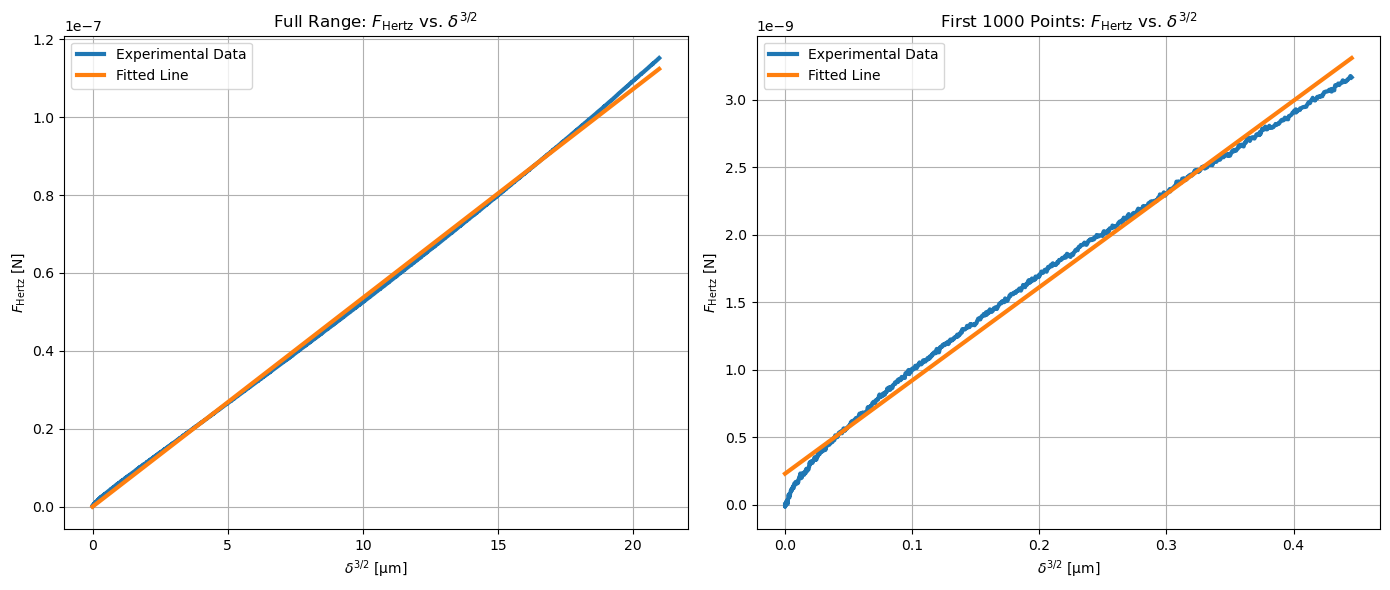

In [31]:
# Given values
R = 12.5e-6  # radius of the spherical tip
r = 15.39e-6  # radius of the microparticle 
R_star = R * r / (R + r)

# Transform displacement
displ_exp_new = displ_exp**(3/2)

# Linear fit (all points)
slope_all, intercept_all = np.polyfit(displ_exp_new, force_exp, 1)
force_exp_fit_all = slope_all * displ_exp_new + intercept_all

# Linear fit (first 1000 points)
slope_1000, intercept_1000 = np.polyfit(displ_exp_new[:1000], force_exp[:1000], 1)
force_exp_fit_1000 = slope_1000 * displ_exp_new[:1000] + intercept_1000

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot full data fit
axs[0].plot(displ_exp_new, force_exp, label='Experimental Data', lw=3)
axs[0].plot(displ_exp_new, force_exp_fit_all, '-', label='Fitted Line', lw=3)
axs[0].set_xlabel(r'$\delta^{3/2}$ [μm]')
axs[0].set_ylabel(r'$F_{\mathrm{Hertz}}$ [N]')
axs[0].set_title(r'Full Range: $F_{\mathrm{Hertz}}$ vs. $\delta^{3/2}$')
axs[0].legend()
axs[0].grid(True)

# Plot first 1000 points fit
axs[1].plot(displ_exp_new[:1000], force_exp[:1000], label='Experimental Data', lw=3)
axs[1].plot(displ_exp_new[:1000], force_exp_fit_1000, '-', label='Fitted Line', lw=3)
axs[1].set_xlabel(r'$\delta^{3/2}$ [μm]')
axs[1].set_ylabel(r'$F_{\mathrm{Hertz}}$ [N]')
axs[1].set_title(r'First 1000 Points: $F_{\mathrm{Hertz}}$ vs. $\delta^{3/2}$')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.savefig("hertz_fit_comparison.png", dpi=300)
plt.show()

- Varying the number of points for the fitting, obtained slope values were plotted.
- Here, $\delta_{max}$ represents the maximum displacment used for the fitting, and it is non-dimensionalized for the plot. 

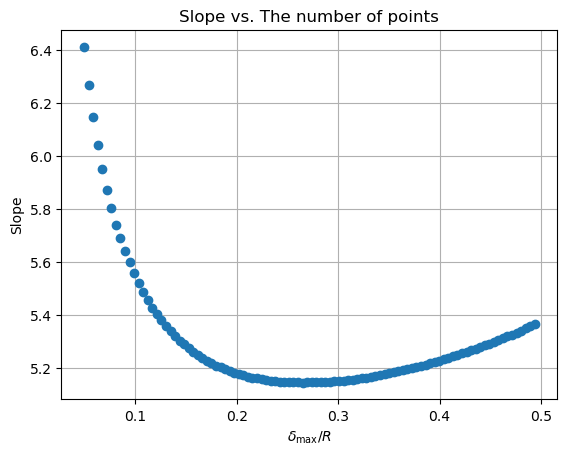

In [32]:
# Slope calculation
total_points = len(displ_exp_new)
ratio_array = np.linspace(0.1,1,100)
max_displ_array = []

slope_list = []
for ratio in ratio_array:

    num_points = int(ratio*total_points)

    max_displ_array.append(displ_exp[num_points-1]/r*1e-6)
    slope, intercept = np.polyfit(displ_exp_new[:num_points], force_exp[:num_points],1)
    slope = slope*1e9
    
    slope_list.append(slope)

plt.figure(3)
plt.plot(max_displ_array, slope_list,'o', lw=3)
plt.xlabel(r'$\delta_{\mathrm{max}}/R$')
plt.ylabel('Slope')
plt.title('Slope vs. The number of points')
plt.grid(True)
plt.show()

- After performing a linear fit of the $ F \text{–} \delta^{3/2} $ curve, we obtain the following relationship ($m$: slope):

$$
\frac{E}{1 - \nu^2} = \frac{3m}{4\sqrt{R^*}}
$$

- Since this equation contains two unknowns—Young’s modulus $E$ and Poisson’s ratio $\nu$—but only one equation, an assumed value for Poisson’s ratio was used, and the corresponding Young’s modulus was calculated accordingly.

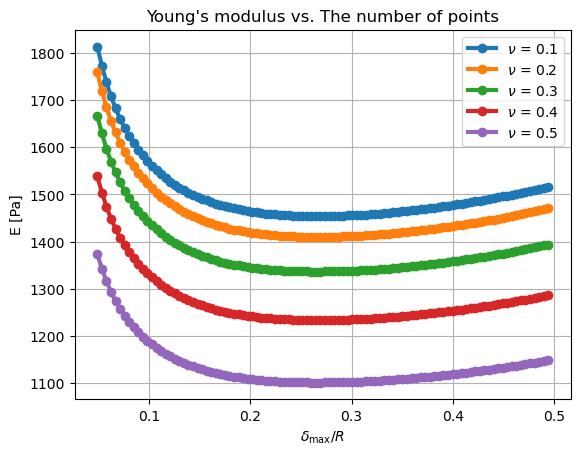

In [33]:
nu_values = [0.1, 0.2, 0.3, 0.4, 0.5]

E_total_list = []

for nu in nu_values:
    E_list = []
    
    for slope in slope_list:
        E = (1-nu**2)*3*slope/(4*np.sqrt(R_star))
        E_list.append(E)

    E_total_list.append(E_list)

plt.figure(4)
for i, nu in enumerate(nu_values):
    plt.plot(max_displ_array, E_total_list[i],'o-', label = fr'$\nu$ = {nu}',lw=3)
    
plt.xlabel(r'$\delta_{\mathrm{max}}/R$')
plt.ylabel('E [Pa]')
plt.title('Young\'s modulus vs. The number of points')
plt.legend()
plt.grid(True)
plt.show()